In [1]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows
#!{sys.executable} -m pip install uproot

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/epp/phrrkw/.local/lib/python3.9/site-packages
sysconfig: /home/epp/phrrkw/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


### Trying to flow from a Gaussian to the LHCb Log10(IP) shape

* The LHCb simulation log10(IP) shape is kinda Gaussian. We want to flow from a Gaussian to there.
* The step after that would be to invert the flow (that is part of their properties), from there to Gaussian.
* A similar flow should be able to flow from Gaussian -> Z IP data shape. 
* Thus you have a 2-step flow procedure of simulation -> Gaussian -> data, which is the transformation we want to learn.

In [42]:
# Let's first load up the simulated data and put it into a 1D numpy array
import numpy as np
import uproot

file = uproot.open("../data/tuple_for_training__DATA.root")
muon_prefix = "mup_"
branch = f'{muon_prefix}IP'
selection = "(1>0)"
sim_ip = file['DecayTree'].arrays(
    branch, cut=selection, library='np')[branch].astype(np.float64)

N_SAMPLES = 10000
sim_log10_ip = np.log10(sim_ip)
# take first N_SAMPLES from sim_log10_ip
sim_log10_ip = sim_log10_ip[:, :N_SAMPLES]
print(sim_log10_ip.shape)

(1, 10000)


In [43]:
import matplotlib.pyplot as plt

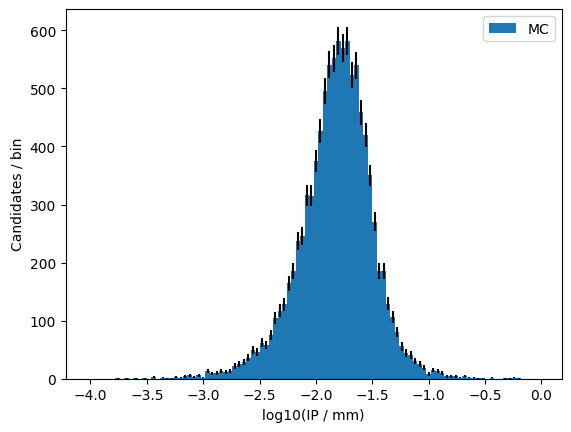

In [44]:
fig, ax = plt.subplots()
hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC')
ax.set_xlabel('log10(IP / mm)')
ax.set_ylabel('Candidates / bin')
ax.legend()
plt.show()


Now we've got the data loaded in, and it looks about right.
Next step is just instance a 1D flow as before.

In [9]:
from nflows import transforms, distributions, flows
import torch

In [50]:
# Define an invertible transformation.
# Need to learn what these transforms do/why we might want to use these.
# This time it's a 1D transform, so just 1 input and output feature.
N_FEATURES = 1
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=4),
    transforms.RandomPermutation(features=N_FEATURES)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
print(base_distribution)

# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)
print(flow)


StandardNormal()
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=4, out_features=2, bias=True)
        )
      )
      (1): RandomPermutation()
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)


Let's take a look at the standard normal

<class 'torch.Tensor'>
torch.Size([1000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487]])


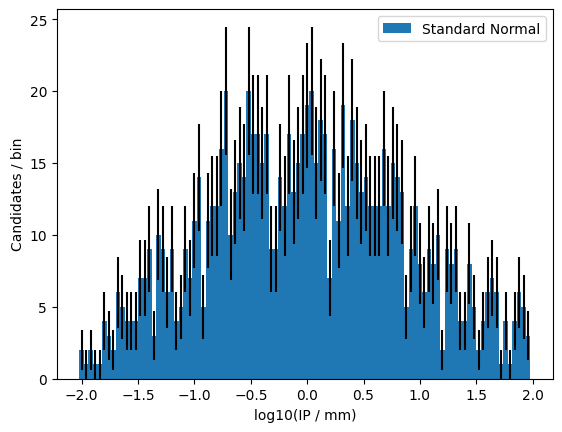

In [46]:
torch.manual_seed(42)
with torch.inference_mode():
    num_samples = 1000
    samples = base_distribution.sample(num_samples)
    print(type(samples))
    print(samples.shape)
    print(samples[:10])

    # Gotta plot them 
    normal_hist, norm_bins = np.histogram(samples, bins=100, range=(-2, 2))
    plt.bar(x=norm_bins[:-1], height=normal_hist, yerr=np.sqrt(normal_hist), width=norm_bins[1] - norm_bins[0], label='Standard Normal')
    plt.xlabel('log10(IP / mm)')
    plt.ylabel('Candidates / bin')
    plt.legend()
    plt.show()

Looks fairly Gaussian to me.
Let's try to train the flow.

In [47]:
# Prepare the target data
# Reshape was needed to swap the axes to match what the flow expects
sim_log10_ip_tensor = torch.tensor(sim_log10_ip, dtype=torch.float32).reshape(-1, 1)
print(sim_log10_ip_tensor[:5])
print(sim_log10_ip_tensor.shape)
print(samples[:5])
print(samples.shape)


tensor([[-1.9285],
        [-1.4633],
        [-1.6164],
        [-1.8332],
        [-2.0260]])
torch.Size([10000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784]])
torch.Size([1000, 1])


Loss at iteration 0: 1.9005982875823975


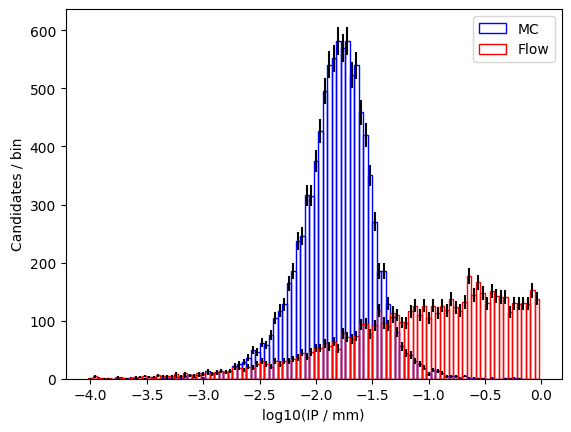

Loss at iteration 200: 0.9896023273468018


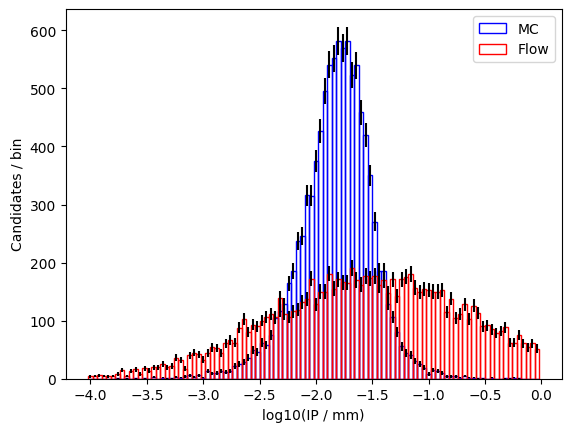

Loss at iteration 400: 0.3361959755420685


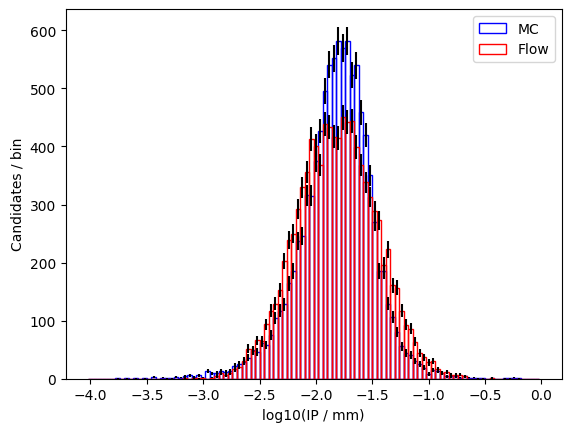

Loss at iteration 600: 0.33489471673965454


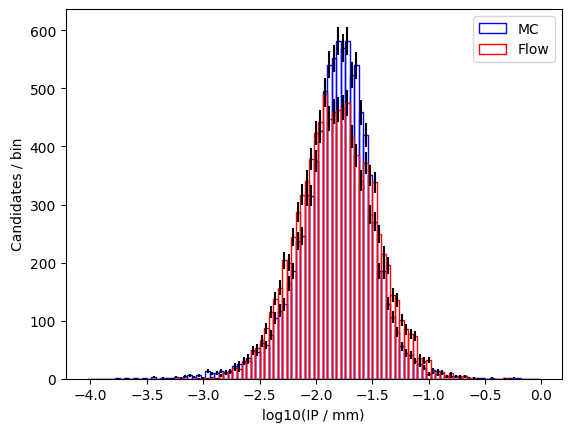

Loss at iteration 800: 0.33489468693733215


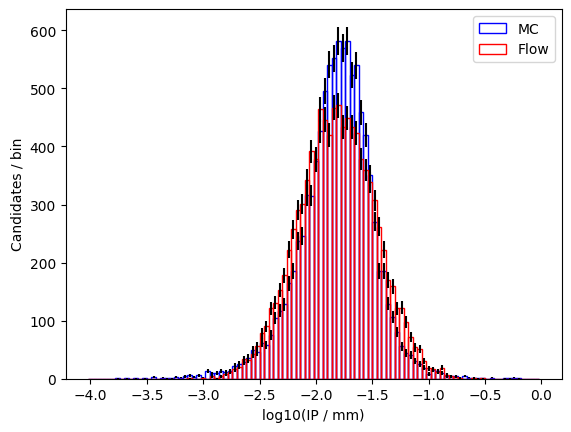

In [51]:
from torch import optim, nn
optimizer = optim.Adam(flow.parameters())
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

So this kinda seems to be working, but it looks like we have a normalisation problem...
Let's try to take the same number of target samples as what we take from the flow.
This should also speed up the training...

Now I've adjusted the normalisations, we can see that the two distributions are getting quite close!
We probably want to do some kind of chi2 metric as the loss function to optimise...